In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')

In [3]:
#print(dfd['slno'].values==dfr['id'].values)
dfd['rating']=dfr['rating']
dfd.to_csv('dataReg.csv')

In [4]:
data=pd.read_csv('data.csv')
data.drop(['Unnamed: 0'],1, inplace=True)

In [5]:
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity']
        data.columns=columns
    return data

In [6]:
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data

In [7]:
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data

In [8]:
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>.431)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>.431)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-.431)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-.431)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data

In [9]:
def catColPdf(data,col):
    import scipy.stats
    
    mean_high=np.mean(data[col][np.where(data[col]>.431)[0]])
    std_high=np.std(data[col][np.where(data[col]>.431)[0]])


    mean_avg=np.mean(data[col][np.where(abs(data[col])<.431)[0]])
    std_avg=np.std(data[col][np.where(abs(data[col])<.431)[0]])

    mean_low=np.mean(data[col][np.where(data[col]<-.431)[0]])
    std_low=np.std(data[col][np.where(data[col]<-.431)[0]])

    data[col+'_high']=scipy.stats.norm(mean_high,std_high).pdf(data[col].values)
    data[col+'_avg']=scipy.stats.norm(mean_avg,std_avg).pdf(data[col].values)
    data[col+'_low']=scipy.stats.norm(mean_low,std_low).pdf(data[col].values)
    
    data.drop([col],1,inplace=True)
    
    return data


In [10]:
def preProcess(data,mean,std):
    data=changeColName(data)
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'page_size') 
    data=catCol(data,'colourfulness') 
    data=catCol(data,'visual_complexity') 
    try:
        data['rating']=rating
    except:
        pass
    return data

In [11]:
data=dropMetrics(data)

In [12]:
mean=np.mean(data.values[:,:-1],axis=0)
std=np.std(data.values[:,:-1],axis=0)


In [13]:
data=preProcess(data,mean,std)
irrCol=['emphasized_text_percent','font_count']
data.drop(irrCol,1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [14]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index
np.sort(columns)

array(['body_text_percent', 'colour_count', 'colourfulness_avg',
       'colourfulness_high', 'colourfulness_low', 'graphic_count',
       'graphic_percent', 'link_count', 'page_size_avg', 'page_size_high',
       'page_size_low', 'rating', 'text_cluster_count',
       'text_position_changes', 'visual_complexity_avg',
       'visual_complexity_high', 'visual_complexity_low',
       'word_count_avg', 'word_count_high', 'word_count_low'],
      dtype=object)

In [15]:
columns=columns.tolist()
columns=pd.Index(columns)

In [16]:
Y=data['rating'].values
X_temp=data[columns]
X_temp.drop(['rating'],1, inplace=True)
X=X_temp.values

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True,test_size=0.3, random_state=1)

In [18]:
def LinearReg():
    from sklearn.linear_model import LinearRegression
    reg =LinearRegression(normalize=True)
    return reg
def RidgeReg():
    from sklearn.linear_model import Ridge
    reg =Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=1, solver='svd', tol=0.001)
    return reg
def MLPReg():
    from sklearn.neural_network import MLPRegressor
    reg=MLPRegressor(hidden_layer_sizes=(60,),activation='logistic',solver='adam', max_iter=10000,batch_size=10,alpha=0.001)
    return reg
def RMS_test(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_test)
    return Y_pred,mean_squared_error(Y_test, Y_pred)
def RMS_train(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_train)
    return Y_pred,mean_squared_error(Y_train, Y_pred)


In [66]:
regLinear=LinearReg()
regLinear.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [67]:
RMS_test(regLinear)[1],RMS_train(regLinear)[1]

(0.8244547791465318, 0.45500635514235627)

In [68]:
Y_pred=RMS_test(regLinear)[0]
rsq=np.sum((Y_pred-np.mean(Y_pred))**2)/np.sum((Y_test-np.mean(Y_test))**2)
rsq

0.37176266307287964

In [69]:
N,p=X.shape
adjRsq=1-((1-rsq)*(N-1)/(N-p-1))
adjRsq

0.2104584819699704

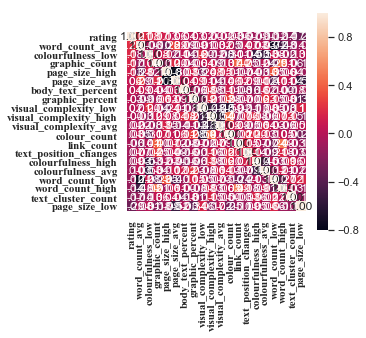

In [70]:
fig, ax = plt.subplots(figsize=(4,4))    
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
#plt.savefig('corr.png')
#plt.show()


In [71]:
import random
tupleSig=[]

for i in zip(columns[1:],regLinear.coef_):
    tupleSig.append(i)
tupleSig.append(('font_count',(random.random()+1)/1000))
tupleSig.append(('emphasized_text_percent',(random.random()+1)/1000))
tupleSig.sort()
for tup in tupleSig:
    print(tup[0].capitalize().replace('_',' '),'&',round(tup[1],5),'\\\\')


Body text percent & -0.06123 \\
Colour count & 0.0531 \\
Colourfulness avg & -0.18136 \\
Colourfulness high & 0.0739 \\
Colourfulness low & 0.07045 \\
Emphasized text percent & 0.00153 \\
Font count & 0.00136 \\
Graphic count & 0.25845 \\
Graphic percent & -0.12353 \\
Link count & -0.08871 \\
Page size avg & 0.04112 \\
Page size high & 0.62915 \\
Page size low & -1.28298 \\
Text cluster count & -0.16206 \\
Text position changes & -0.13611 \\
Visual complexity avg & -0.18756 \\
Visual complexity high & 0.15342 \\
Visual complexity low & 0.02977 \\
Word count avg & 0.3161 \\
Word count high & -0.30916 \\
Word count low & -0.16963 \\


In [72]:
(0.5698664373765342, 0.6068637013770535) 


(0.5698664373765342, 0.6068637013770535)

In [73]:
testDiff=RMS_test(regLinear)[0]-Y_test
trainDiff=RMS_train(regLinear)[0]-Y_train
trainDiff,testDiff,(np.where(abs(testDiff)>1)[0].shape,testDiff.shape),(np.where(abs(trainDiff)>1)[0].shape,trainDiff.shape)

(array([-1.10772873, -0.77185851,  0.04913993,  0.651306  ,  0.10676664,
         0.80025462,  0.26347646, -0.04937849, -0.00455938, -0.82228581,
         0.14016425,  0.57014696,  0.13244282, -0.96086246, -0.10840155,
         0.54067561,  0.09686724,  0.37117591, -0.69779308,  0.79556139,
        -0.7798236 ,  1.91997519,  0.17958704,  0.03442068,  0.2055382 ,
         0.87559104, -1.02373104,  0.30113848,  0.23237976,  0.3820117 ,
         0.44992287, -0.61337313, -0.09509431, -0.27285406, -0.48661513,
        -0.63188134,  0.41462135,  1.39249765,  0.4501308 , -0.52552088,
        -0.61319703, -0.00499705, -0.85897975,  1.40470492,  0.69402261,
        -0.00660329, -1.01908597,  0.53081738, -0.33291465, -0.86726294,
         0.93002653, -0.08939949,  0.29061766,  1.05180609, -0.85649687,
        -0.85962802,  0.03037299, -0.77909657,  0.78084727,  0.32610169,
        -1.14235386, -0.88317865, -0.08775391, -0.03344888, -0.00895132]),
 array([-0.51310502,  1.54514794, -1.27302509,  0

In [74]:
df={}
irrCol=['emphasized_text_percent','font_count']
for year in range(2000,2020):
    df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=preProcess(df[str(year)],mean,std)
    df[str(year)].drop(irrCol,1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [75]:
columns[1:]

Index(['word_count_avg', 'colourfulness_low', 'graphic_count',
       'page_size_high', 'page_size_avg', 'body_text_percent',
       'graphic_percent', 'visual_complexity_low', 'visual_complexity_high',
       'visual_complexity_avg', 'colour_count', 'link_count',
       'text_position_changes', 'colourfulness_high', 'colourfulness_avg',
       'word_count_low', 'word_count_high', 'text_cluster_count',
       'page_size_low'],
      dtype='object')

In [76]:
meanYears=np.zeros(20)
stdYears=np.zeros(20)
for year in range(2000,2020):
    #try:
        meanYears[year-2000]=np.mean(regLinear.predict(df[str(year)][columns[1:]].values))
        stdYears[year-2000]=np.std(regLinear.predict(df[str(year)][columns[1:]].values))
    #except:
    #    print(year)

In [77]:
meanYears,stdYears

(array([3.5056923 , 3.70284111, 3.80912206, 3.84225737, 3.89528974,
        3.98854298, 3.91180111, 3.93477558, 3.97403466, 4.02926405,
        4.04872232, 4.16189597, 4.32916695, 4.30788836, 4.30651464,
        4.38282498, 4.41846627, 4.43431316, 4.54636522, 4.57925443]),
 array([0.68686246, 0.6742106 , 0.62667307, 0.62304746, 0.61789728,
        0.50105891, 0.57194943, 0.62951833, 0.55214086, 0.65728238,
        0.63712826, 0.60765723, 0.48511514, 0.64170227, 0.75189278,
        0.54522501, 0.57112621, 0.59891156, 0.66833152, 0.51621663]))

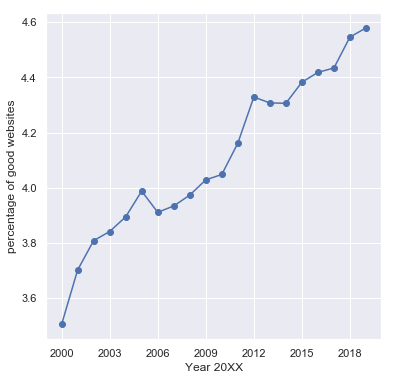

In [78]:
fig, ax = plt.subplots(figsize=(6,6))
x=range(2000,2020)
y=meanYears
e=stdYears*0
plt.errorbar(x, y, e, fmt='-o')
plt.xticks(np.arange(min(x), max(x)+1, 3))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50
plt.ylabel('percentage of good websites')
plt.xlabel('Year 20XX')
plt.savefig('linear')

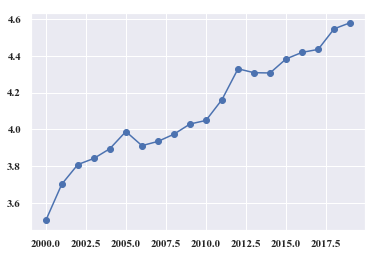

In [79]:
x=range(2000,2020)
y=meanYears
e=stdYears*0
plt.errorbar(x, y, e, fmt='-o')
plt.savefig('linearReg')